# HW-1 - Predicting Sentence Similarity
In lecture 1 we saw several techniques for sentence embedding. The most simple one which also leads to competitive results is simply taking the average of pre-trained word embedding. Therefore, in this exercise, we will explore the STS dataset and we will see how can we improve the existing word embedding to better handle this task.

# * Submitted by David Lasry and Nitzan Tal *

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



## 1 - Package installation

For some of the methods below, we also need the word frequencies estimated from the corpus. As we currently don't have this available for the GloVe pretrained vectors / Common Crawl corpus, we use the wordfreq package (https://github.com/LuminosoInsight/wordfreq/)

We will use the STS dataset which was intorduced in class (from the datasets-sts repo: https://github.com/brmson/dataset-sts) the dataset contains sentence pairs and their corresponding similarity score based on human judgments. 

Moreover, for word emneddings we will use GloVe - Global Vectors for Word Representation (https://nlp.stanford.edu/projects/glove/). Pre-trained word vectors trained on the 840 billion token Common Crawl corpus: http://nlp.stanford.edu/data/glove.840B.300d.zip) - *The download may take a while*

In [3]:
!pip install wordfreq
!git clone https://github.com/brmson/dataset-sts
#!curl  http://nlp.stanford.edu/data/glove.840B.300d.zip --create-dirs -o "/content/drive/MyDrive/nlp/glove.840B.300d.zip"
!wget  http://nlp.stanford.edu/data/glove.840B.300d.zip "drive/MyDrive/nlp/glove.840B.300d.zip"

     |████████████████████████████████| 56.9MB 74kB/s 
     |████████████████████████████████| 174kB 11.4MB/s 
     |████████████████████████████████| 727kB 37.6MB/s 
  Created wheel for wordfreq: filename=wordfreq-2.5.0-cp37-none-any.whl size=56830860 sha256=547499f2b5a95ef7ac5ce8b882737ae95f3222dc60a58685ecad0172beec9c6a
  Stored in directory: /root/.cache/pip/wheels/b0/57/ab/4e4c8686c903dc68d3f405b5c8090218fdd2fd3997b86c8a47
  Created wheel for langcodes: filename=langcodes-3.1.0-cp37-none-any.whl size=165888 sha256=c90ff8b7b1ba6381dd53d94fe67b634d873a1dc3d41266468a2d8e178708a28e
  Stored in directory: /root/.cache/pip/wheels/78/57/10/167a0f1c07409a7b72d8d08391fa9739ef37e834695575ccc8
Successfully built wordfreq langcodes
  Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20
Cloning into 'dataset-sts'...
remote: Enumerating objects: 3477, done.
remote: Total 3477 (delta 0), reused 0 (delta 0), pack-reused 3

We will convert the downloaded word embedding to a dictionary for further usage.

In [4]:
import pandas as pd
import zipfile

z = zipfile.ZipFile("drive/MyDrive/nlp/glove.840B.300d.zip")
glove_pd = pd.read_csv(z.open('glove.840B.300d.txt'), sep=" ", quoting=3, header=None, index_col=0)
glove = {key: val.values for key, val in glove_pd.T.items()}
del glove_pd



After this you can easily access the word embedding by accessing a dictionary

In [5]:
glove['test'].shape

(300,)

If we want to acess the frequency of a specific word it can be done easily using wordfreq (note that in general it would have been better to calculate the word frequency based on our on corpus)

In [6]:
import wordfreq
wordfreq.word_frequency('test', 'en', wordlist='large')

0.000155

## 2 - Loading the datasets


In [7]:
%matplotlib inline
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import sys
sys.path.append('./dataset-sts/')
import pysts
from pysts.loader import load_sts

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Now we will load the 2015 STS dataset on the healines segement. As you can see each example is composed by two sentences s0 and s1 and a label

In [8]:
s0, s1, labels = load_sts("dataset-sts/data/sts/semeval-sts/2015/headlines.test.tsv")
s=s0+s1
len(s)

1500

In [9]:
print(f"Sentence A: {s0[0]}")
print(f"Sentence B: {s1[0]}")
print(f"Label: {labels[0]}")


Sentence A: ['The', 'foundations', 'of', 'South', 'Africa', 'are', 'built', 'on', 'Nelson', 'Mandela', "'s", 'memory']
Sentence B: ['Australian', 'politicians', 'lament', 'over', 'Nelson', 'Mandela', "'s", 'death']
Label: 1.3



## 3. Predict similarity between sentences based on GloVe
To predict the similarity between two sentences, the word embeddings (using the GloVe word vectors) are combined into a sentence embedding.

Similarity is calculate as the cosine similarity of the two sentence embeddings, and the overall performance is evaluated as the Pearson's coefficient between the predicted scores and the labels.



In [10]:
# Implement the following functions:
# 1.  A function which gets as an input a sentence and returns the average of it's word embedding.
# 2.  A function which gets as an input two sentence embeddings and returns their cosine-similarity
# 3.  A function which gets the the predicted scores and the labels and returns the pearson's r coefficent Tip: For calculating the pearson's r coefficent you can use from scipy.stats import pearsonr

In [17]:
def sent2wv(sentence):
  default=np.zeros(300)
 
  wv_arr=np.zeros((len(sentence), 300))
  i=0
  for word in sentence:
    try:
      wv_arr[i] =glove[word]#, default)
      i=i+1    
    except:
      #print(word)
      wv_arr[i]= default
      i=i+1
      continue
  return np.mean(wv_arr[:i], axis=0)


One implementation note: some words didn't have a glove embedding (misspelled words, numbers, rare words etc.). We tried 2 different approaches to handle it: 1. As implemented above - replace the missing embedding with default value of zero 2. Calculate the average of the sentence when omitting this word. Empiraclly, the 1st approach gave a slight improvement in the final question so we chose it.

In [12]:
from sklearn.metrics import pairwise
def cos_similar(v1, v2):
  v1=v1.reshape(1,-1)
  v2=v2.reshape(1,-1)
  return pairwise.cosine_similarity(v1, v2)[0,0]

In [13]:
from scipy.stats import pearsonr
def corr_pred(labels, predictions):
  return pearsonr(labels,predictions)

You can check the implementation using a small batch of the data

In [14]:
Small_batch = (s0[:10],s1[:10])
v1= sent2wv(Small_batch[0][0])
v2= sent2wv(Small_batch[1][0])
cos_similar(v1,v2)

0.7521085001924898

Now we will evaluate the method across all the STS datasets using the following function which loops over all the datasets. The desired output is a table which shows Pearson's coefficent on each dataset.

In [15]:
files = glob.glob("dataset-sts/data/sts/semeval-sts/all/*.test.tsv")

def evaluate_tasks(files, embed_func):

    tests = []
    scores = []
     
    for f in files:#[0:10]:
        s0, s1, labels = load_sts(f)
        sent_pairs=zip(s0,s1)
         
        lst_wv=[(embed_func(s[0]), embed_func(s[1]))  for s in list(sent_pairs)]
        
        preds=[cos_similar(wv[0],wv[1]) for wv in lst_wv]
       
        scores+=preds
        tests+=list(labels)

    print(len(tests), len(scores))
    print(corr_pred(tests, scores))
    return 0




In [18]:
evaluate_tasks(files,sent2wv)

18544 18544
(0.35524161411525124, 0.0)


0

## 4. Predict similarity between sentences based on inverse-frequency weighted GloVe

Now we will see how we can improve our embedding using inverse-frequency weighted average. Which means that instead of taking regular average we will now take a weighted avarage where the weight for each word will be it's inverse frequency. 

We remind you that the word frequency can be calculated using the wordfreq 
package. As before the final result should be a table with the reported Pearson's coeefiecnt. Place the result from this section next to the results from above so we can spot the diffrences.


TIP: In order to avoid numerical issues instead of multiplying by 1/freq you sould multiply by a / (a + freq) for some small a (e.g. 1e-3)


In [19]:
 def sent2wv_inv_freq(sentence,  a=1e-3):
 
 
  wv_arr=np.zeros((len(sentence), 300))
  weight=np.zeros(len(sentence))
  i=0
  for word in sentence:
    try:
      wv_arr[i] =glove[word]#, default)
       
      weight=a/(a+wordfreq.word_frequency(word, 'en', wordlist='large'))
      wv_arr[i]=wv_arr[i]*weight
      i=i+1    
    except:
      i=i+1  
      continue
  
  return np.mean(wv_arr, axis=0)
  


In [20]:
Small_batch = (s0[:10],s1[:10])
v1= sent2wv_inv_freq(Small_batch[0][0])
v2= sent2wv_inv_freq(Small_batch[1][0])
print(v1.shape,v2.shape)

(300,) (300,)


In [21]:
evaluate_tasks(files,sent2wv_inv_freq)

18544 18544
(0.49748807002435247, 0.0)


0

#Question

Does this method improve the first approach? If yes why?

The 2nd method improves the 1st approach - taking the inverse frequency meand that less frequent words weigh more and has more impact on the representation. This makes sense as the less frequent words are more context-specific(e.g. badmington) in comparison to more frequent words (e.g. 'more') hence have more distinctive value.  

## 5. Predict similarity between sentences based on  first common component removal

We will add to the weighted average from above the removal of the first common components

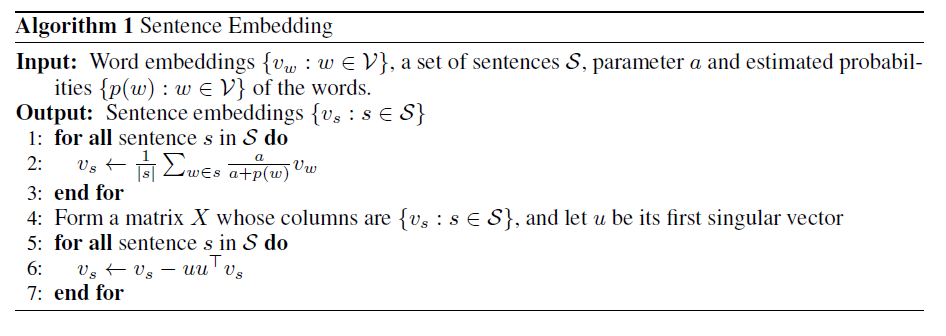

As you can observe we already implmented lines 1-3. So all we have to do is to implment lines 4-6 in the above algorithm.

Place the result from this section next to the results from above so we can spot the diffrences.


In [22]:
from sklearn.decomposition import TruncatedSVD
#from scipy import linalg


def get_singular():
  all_sent=[]
  for f in files:
          s0, s1, labels = load_sts(f)
          all_sent=all_sent+s0+s1
  print(len(all_sent))
  all_wv = np.zeros((300, len(all_sent)))
  for i, sent in enumerate(all_sent):
    all_wv[:,i]= sent2wv_inv_freq(sent)
 # U, s, Vh = linalg.svd(all_wv)
  #print(U[:,0]) 
  svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
  svd.fit(all_wv.T)
 
  return svd.components_[0] 
   
v_sing=get_singular() 
  

37088


In [23]:
v_sing

array([-2.01809185e-02,  3.86303674e-02, -1.04974448e-02, -9.01572056e-03,
        1.60170014e-02, -1.12352908e-02, -3.69639174e-02, -7.09485787e-03,
       -1.89656308e-02,  7.59185674e-01, -6.04317802e-02,  1.63889366e-02,
        1.30433766e-02, -9.32479668e-03, -6.61442533e-02, -1.04466730e-03,
       -2.56035014e-02,  3.44645624e-01, -4.51519766e-02,  1.14625499e-03,
       -7.03042341e-03,  1.27672710e-02, -2.34442222e-03,  6.43816087e-03,
        2.03095633e-02,  1.15084457e-03, -3.82990045e-02, -9.02182450e-03,
        1.18927859e-02, -9.84558120e-03, -2.47896104e-02, -8.18199297e-04,
       -2.65877291e-02,  3.39131818e-03,  4.79857220e-02, -7.43527808e-03,
        3.10071377e-02,  1.45344119e-03,  1.34555198e-02, -1.01917189e-02,
        8.04388865e-03, -1.51987324e-02,  3.73245214e-02, -2.35811133e-02,
        5.11753520e-03, -1.20451966e-02, -4.81269537e-02,  7.38413010e-03,
       -2.22579176e-02,  3.75856895e-03, -1.65822275e-02,  1.24894797e-02,
       -1.47189052e-02,  

In [24]:
def sent2wv_singular(sent, singular=v_sing):
  v=sent2wv_inv_freq(sent)
  
  v=v-np.dot(singular,np.dot(singular,v))
   
  return v
 

In [25]:
evaluate_tasks(files,sent2wv_singular)

18544 18544
(0.6583512891846137, 0.0)


0

## Final Question

Please provide an explanation why does the method above work? 


By substtarcting the first principal component which is explains  or responsible for most of the variance, we are denoising the data in some way - it seems that most of the variance in the sentences embeddings is either unrelated directly to the sentences meanings (e.g. it is related to sentences length or some syntactic features) or unrelated to the sentences distintictive meaning, i.e. it is related to the occurence of more common words which obscure the essential meaning of the sentence. This way we focus on the other components - other sources of variance which are apperently more distinctively meaningful

#Final Comment

In class we saw two methods for evaluting embeddings. Intrinsic and Extrinsic. Extrinsic is when we use the embeddings as a building block for a down-stream task (e.g., sentiment analysis classification etc.). Intrinsic is when we explore the embedding space trying to measure useful linguistic phenomena. 
The method you have seen in this HW is intrinsic.